Helper functions:

In [21]:
def my_callback(meanfield, elbo, n):
    if n%2000 == 0:# and n>200:
        acc = print_acc_from_trace(meanfield, n)
        accs.append(acc)
        ns.append(n)
def ppc_to_pred(ppc):
    pred = []
    for i in range(ppc['out'].shape[1]): # for X_test samples
        one_sample = []
        for j in range(ppc['out'].shape[0]):
            one_sample.append(ppc['out'][j][i])
        sums = np.zeros(lenA)
        for s in one_sample:
            sums[s] += 1

        pred.append(np.argmax(sums))
    return np.array(pred)

Used in callback. Computes, prints and saves the accuracy at this point of learning

In [24]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"ann_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

# Task 10.9. Three models

## M. 1: Target object + scene + target object

In [10]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import os
from copy import deepcopy
from deepdiff import DeepDiff

from sklearn.model_selection import train_test_split

from submodules.Scenes import Scene
from submodules.features import Features

%config InlineBackend.figure_format = 'retina'
floatX = aesara.config.floatX
rng = np.random.default_rng(5165)
az.style.use("arviz-darkgrid")

Hyperparameters:

In [11]:
dataset_name = 'D1'
train_samples = 6000 

In [12]:
# dataset 
data = np.load(f"{os.path.expanduser('~')}/Documents/{dataset_name}.npy", allow_pickle=True)
config = data.item()['config']
A = config['A']
G = config['G']
lenG = config['lenG']
lenA = config['lenA']
Otypes = config['Otypes']
lenOtypes = config['lenOtypes']
CM = config['CM']
dataset = data.item()['dataset']

In [13]:
def get_X_Y(dataset):
    X = np.zeros([len(dataset),len(dataset[0][2])])
    Y = np.zeros((len(dataset)), dtype=tuple)
    for n,sample in enumerate(dataset):
        s = Scene(init='from_dict', import_data=sample[0])

        X[n] = sample[2]
        Y[n] = A.index(sample[1][0])
    return X, Y

X,Y = get_X_Y(dataset)

In [14]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-(train_samples/10000))

In [15]:
n_obs_in = lenG

In [16]:
def construct_nn(ann_input, ann_output):
    n_hidden = lenA
    
    # Initialize the weights/policy values
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)

        # Weights/policy symbolic variable
        weights_in_1 = pm.Normal(
            "policy", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )
        act_out = pm.math.sigmoid(pm.math.dot(ann_input, weights_in_1))
        out = pm.Categorical(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],
        )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

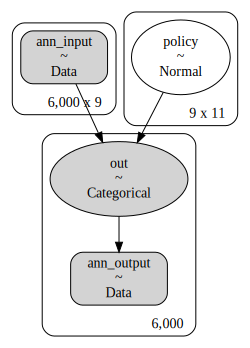

In [17]:
pm.model_to_graphviz(neural_network)

In [18]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"ann_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [25]:
ns = []
accs = []
#method = pm.ADVI()
neural_network = construct_nn(X_train, Y_train)
with neural_network:
    approx = pm.fit(n=25_000, callbacks=[my_callback])#, method=method)

n: 2000, Accuracy = 17.5%


Interrupted at 2,226 [8%]: Average Loss = 13,663


Results of Model 1 (1L, 11 Hidden layer size fixed):
- Dataset 1:
    - M(100 s) = 18
    - M(200 s) = 25
    - M(400 s) = 40
    - M(1000 s) = 62
    - M(2500 s) = 67
    - M(5000 samples) = 70
    - M(9000 samples) = 67    
- Dataset 2:
    - M(5000 samples) = 68
- Dataset 3:
    - M(5000 samples) = 68
    - M(1000 s ) = 63
    - M(100 s) = ~18

Text(0, 0.5, 'accuracy [%]')

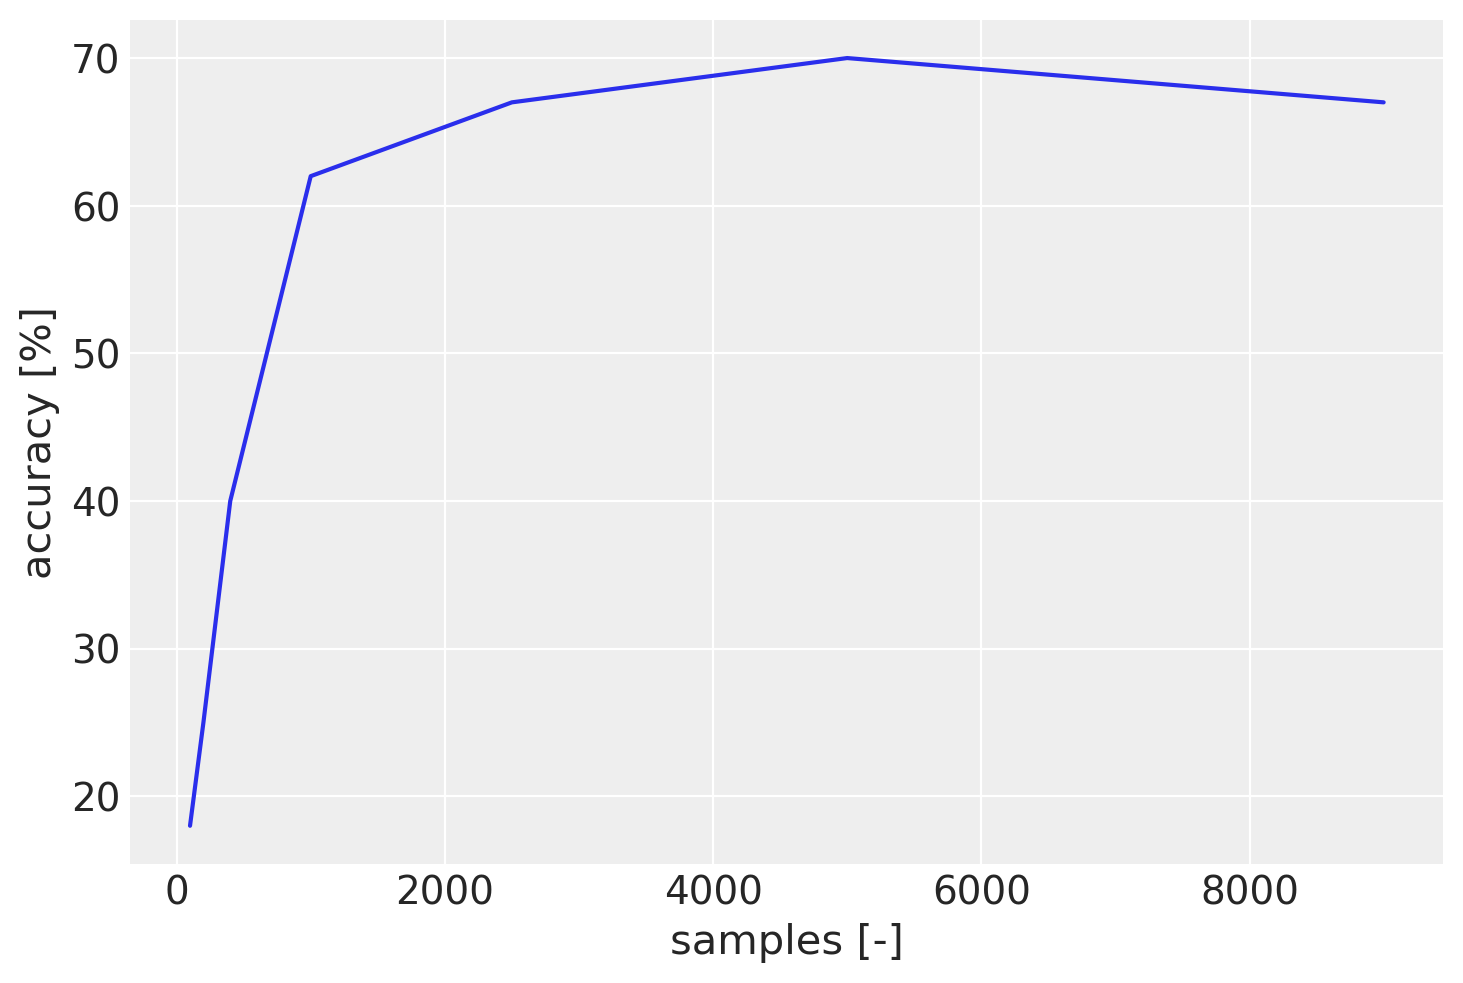

In [26]:
plt.plot([100,200,400,1000,2500,5000,9000], [18,25,40,62,67,70,67])
plt.xlabel("samples [-]")
plt.ylabel("accuracy [%]")

## M. 2: Model 2: Target object + scene + target object

- D1,8000samples,3LW,nhid=25,scene features <52 -> not learning
- D2,8000samples,3LW,nhid=25,scene features <52 -> ?


In [27]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import os
from copy import deepcopy
from deepdiff import DeepDiff

from sklearn.model_selection import train_test_split

from submodules.Scenes import Scene
from submodules.features import Features

%config InlineBackend.figure_format = 'retina'
floatX = aesara.config.floatX
rng = np.random.default_rng(5165)
az.style.use("arviz-darkgrid")

In [28]:
dataset_name = 'D2'
n_scene_features = 52
train_samples = 6000 

In [29]:
# dataset 
data = np.load(f"{os.path.expanduser('~')}/Documents/{dataset_name}.npy", allow_pickle=True)
config = data.item()['config']
A = config['A']
G = config['G']
lenG = config['lenG']
lenA = config['lenA']
Otypes = config['Otypes']
lenOtypes = config['lenOtypes']
CM = config['CM']
dataset = data.item()['dataset']

In [30]:
def get_X_Y(dataset):
    X = np.zeros([len(dataset),len(dataset[0][2])+n_scene_features])
    Y = np.zeros((len(dataset)), dtype=tuple)
    for n,sample in enumerate(dataset):
        s = Scene(init='from_dict', import_data=sample[0])
        obs = s.scene_to_observation(type=1)
        
        ll = len(sample[2]) + len(obs)
        X[n,0:ll] = [*sample[2], *obs]
        Y[n] = A.index(sample[1][0])
    return X, Y

X,Y = get_X_Y(dataset)

In [31]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-(train_samples/10000))

In [32]:
# TODO:
n_obs_in = lenG + n_scene_features

In [33]:
def construct_nn(ann_input, ann_output):
    n_hidden = 25

    # Initialize random weights between each layer
    init_weights_1 = rng.standard_normal(size=(n_obs_in, n_hidden)).astype(floatX)
    init_weights_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_weights_3 = rng.standard_normal(size=(n_hidden, lenA)).astype(floatX)
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "hidden_layer_3": np.arange(n_hidden),
        "train_cols": np.arange(n_obs_in),
        "out_dim": np.arange(lenA),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", ann_input)
        ann_output = pm.Data("ann_output", Y_train)

        # Weights from input to hidden layer
        weights_1 = pm.Normal(
            "weights_1", 0, sigma=1, initval=init_weights_1, dims=("train_cols", "hidden_layer_1")
        )
        weights_2 = pm.Normal(
            "weights_2", 0, sigma=1, initval=init_weights_2, dims=("hidden_layer_1", "hidden_layer_2")
        )
        weights_3 = pm.Normal(
            "weights_3", 0, sigma=1, initval=init_weights_3, dims=("hidden_layer_2", "out_dim")
        )
        
        act_1   = pm.math.tanh(pm.math.dot(ann_input, weights_1))
        act_2   = pm.math.tanh(pm.math.dot(weights_1, weights_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_1, weights_3))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Categorical(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

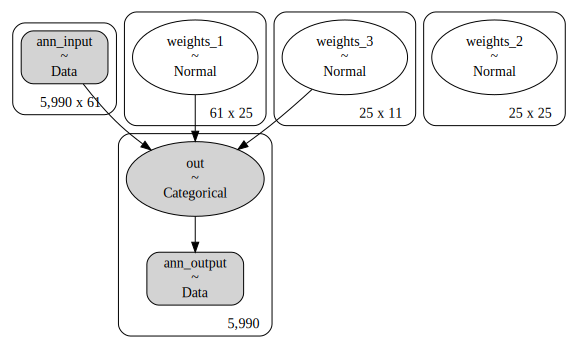

In [34]:
pm.model_to_graphviz(neural_network)

In [35]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"ann_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [36]:
ns = []
accs = []
#method = pm.ADVI()
neural_network = construct_nn(X_train, Y_train)
with neural_network:
    approx = pm.fit(n=25_000, callbacks=[my_callback])#, method=method)

Interrupted at 245 [0%]: Average Loss = 26,981


# Compare three models as a histogram of accuracies

In [37]:
model1_accs = [70,68,68]
model2_accs = [18,17,18]
model3_accs = [0,0,0]

/tmp/ipykernel_25900/1647915420.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


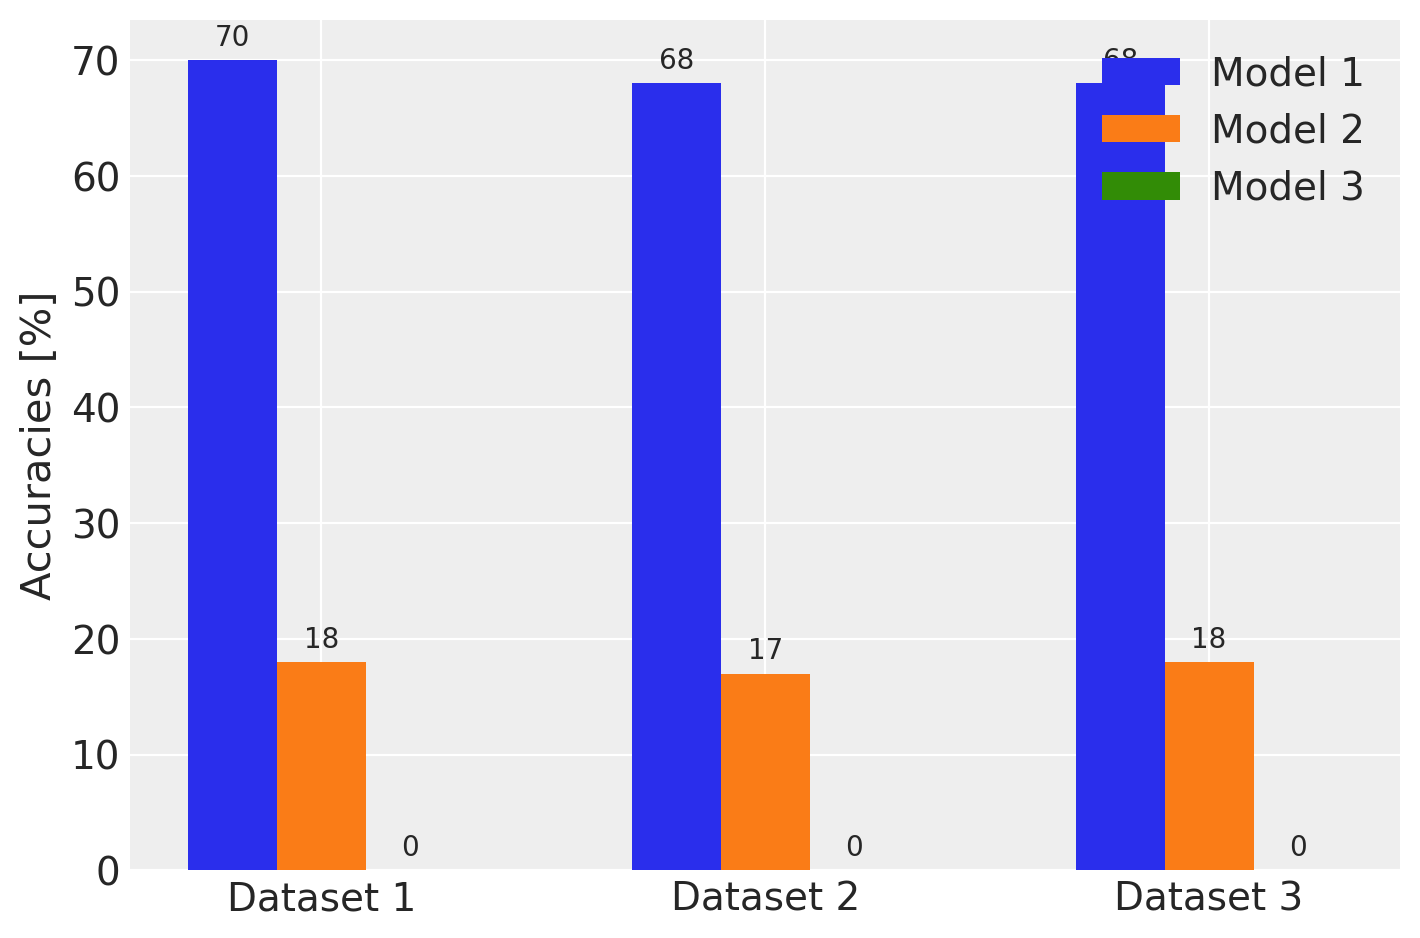

In [38]:
labels = ['Dataset 1', 'Dataset 2', 'Dataset 3']

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, model1_accs, width, label='Model 1')
rects2 = ax.bar(x        , model2_accs, width, label='Model 2')
rects3 = ax.bar(x + width, model3_accs, width, label='Model 3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracies [%]')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()